In [1]:
import pandas as pd
import pymc_marketing as pmm
import matplotlib as mpl
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [3]:
agent_df = pd.read_pickle('agent_output_A_ADS_ONLY.pkl')
joint_calendar_df = pd.read_pickle('joint_calendar_A_ADS_ONLY.pkl')

In [4]:
# Reset index and move it to columns
agent_df_reset = agent_df.reset_index()

# Create a date range starting from '2021-01-03' with a frequency of one week
# The number of periods is the number of unique 'Step' values in agent_df
dates = pd.date_range(start='2021-01-03', periods=agent_df_reset['Step'].nunique(), freq='W')

# Create a DataFrame mapping 'Step' to 'Date'
step_to_date = pd.DataFrame({'Step': range(0, len(dates)), 'Date': dates})

# Merge this DataFrame with agent_df to add the 'Date' column
agent_df_reset = agent_df_reset.merge(step_to_date, on='Step')

# Set 'Step' and 'AgentID' back as indices
agent_df = agent_df_reset.set_index(['Step', 'AgentID'])

In [5]:
def calculate_total_purchases(agent_df):
    '''
    Computes total purchases per brand per step from agent level output
    Used as sanity check for model level output
    '''
    # Initialize empty lists to store the results
    total_purchases_A = []
    total_purchases_B = []
    dates = []
    steps = []

    # Iterate over the 'Purchased_This_Step' column
    for index, row in agent_df.iterrows():
        # Append the number of purchases for each brand to the respective list
        total_purchases_A.append(row['Purchased_This_Step']['A'])
        total_purchases_B.append(row['Purchased_This_Step']['B'])
        dates.append(row['Date'])
        steps.append(index[0])  # Assuming 'Step' is the first level of the index

    # Create a new DataFrame with the total purchases for each brand
    total_purchases_df = pd.DataFrame({
        'Total_Purchases_A': total_purchases_A,
        'Total_Purchases_B': total_purchases_B,
        'Date': dates,
    })

    # Group by 'Date' and 'Step' and sum the purchases
    total_purchases_df = total_purchases_df.groupby(['Date']).sum().reset_index()

    return total_purchases_df

In [6]:
total_purchases_df = calculate_total_purchases(agent_df)

In [7]:
# Also add price, tv and web ad spend columns for A and B to the total_purchases_df dataframe
total_purchases_df['Price_A'] = joint_calendar_df[('A', 'price')]
total_purchases_df['Price_B'] = joint_calendar_df[('B', 'price')]
total_purchases_df['TV_A'] = joint_calendar_df[('A', 'TV')]
total_purchases_df['Web_A'] = joint_calendar_df[('A', 'Web')]
total_purchases_df['TV_B'] = joint_calendar_df[('B', 'TV')]
total_purchases_df['Web_B'] = joint_calendar_df[('B', 'Web')]
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Purchases_A'] * total_purchases_df['Price_A']
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Purchases_B'] * total_purchases_df['Price_B']


In [8]:
# Set correct data types
total_purchases_df['Price_A'] = total_purchases_df['Price_A'].astype(float)
total_purchases_df['Price_B'] = total_purchases_df['Price_B'].astype(float)
total_purchases_df['Total_Purchases_A'] = total_purchases_df['Total_Purchases_A'].astype(float)
total_purchases_df['Total_Purchases_B'] = total_purchases_df['Total_Purchases_B'].astype(float)
total_purchases_df['Total_Sales_A'] = total_purchases_df['Total_Sales_A'].astype(float)
total_purchases_df['Total_Sales_B'] = total_purchases_df['Total_Sales_B'].astype(float)
total_purchases_df['TV_A'] = total_purchases_df['TV_A'].astype(float)
total_purchases_df['Web_A'] = total_purchases_df['Web_A'].astype(float)
total_purchases_df['TV_B'] = total_purchases_df['TV_B'].astype(float)
total_purchases_df['Web_B'] = total_purchases_df['Web_B'].astype(float)

In [9]:
data_A = total_purchases_df[['Date','Total_Sales_A','TV_A','Web_A']]

In [10]:
data_A['t'] = range(len(data_A))


/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_40891/549434617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_A['t'] = range(len(data_A))


In [12]:
data_a_mod = data_A[5:].reset_index(drop=True)

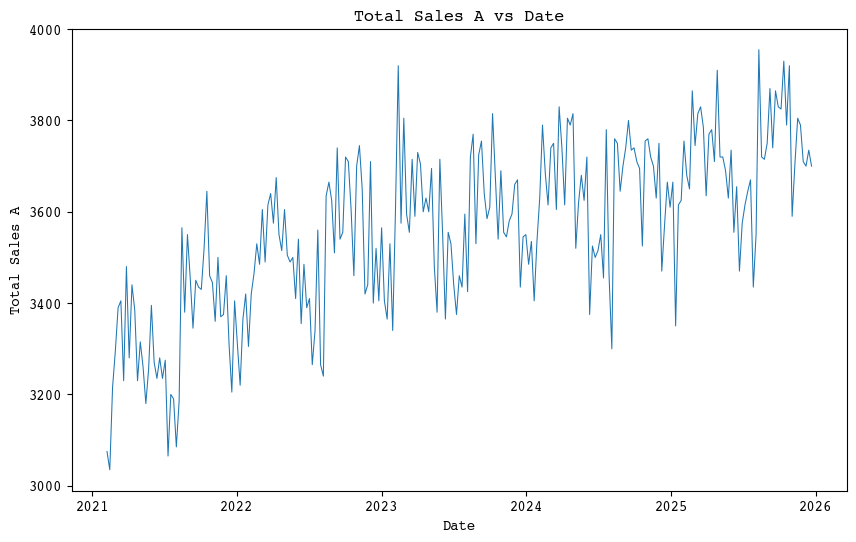

In [13]:
plt.figure(figsize=(10,6))
plt.plot(data_a_mod['Date'], data_a_mod['Total_Sales_A'])
plt.xlabel('Date')
plt.ylabel('Total Sales A')
plt.title('Total Sales A vs Date')
plt.show()


In [54]:
# Define the columns
date_column = 'Date'
channel_columns = ['TV_A', 'Web_A']

my_sampler_config = {
    'tune': 1000,
    'draws': 1000,
    'chains': 4,
    #'target_accept': 0.9  # Increase this value to increase target_accept
}

# Instantiate the model
mmm = pmm.mmm.delayed_saturated_mmm.DelayedSaturatedMMM(
    sampler_config=my_sampler_config,
    date_column=date_column,
    channel_columns=channel_columns,
    control_columns=None,
    adstock_max_lag=8,
    yearly_seasonality=None,
    time_varying_intercept=True
)

In [55]:
# Split data into predictors (X) and target (y)
X = data_a_mod.drop('Total_Sales_A', axis=1)
y = data_a_mod['Total_Sales_A']

# Fit the model
mmm.fit(X, y)

/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/pymc/model/core.py:988: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_time_varying_multiplier_eta, intercept_time_varying_multiplier_ls, intercept_time_varying_multiplier_hsgp_coefs, intercept_base, beta_channel, alpha, lam, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [56]:
import arviz as az
import pymc as pm
import seaborn as sns

In [57]:
mmm.fit_result

<xarray.Dataset> Size: 80MB
Dimensions:                                       (chain: 4, draw: 1000,
                                                   channel: 2, date: 255, m: 200)
Coordinates:
  * chain                                         (chain) int64 32B 0 1 2 3
  * draw                                          (draw) int64 8kB 0 1 ... 999
  * channel                                       (channel) <U5 40B 'TV_A' 'W...
  * date                                          (date) datetime64[ns] 2kB 2...
  * m                                             (m) int64 2kB 0 1 ... 198 199
Data variables: (12/14)
    alpha                                         (chain, draw, channel) float64 64kB ...
    beta_channel                                  (chain, draw, channel) float64 64kB ...
    channel_adstock                               (chain, draw, date, channel) float64 16MB ...
    channel_adstock_saturated                     (chain, draw, date, channel) float64 16MB ...
    channel_contributions                         (chain, draw, date, channel) float64 16MB ...
    intercept                                     (chain, draw, date) float64 8MB ...
    ...                                            ...
    intercept_time_varying_multiplier_eta         (chain, draw) float64 32kB ...
    intercept_time_varying_multiplier_hsgp_coefs  (chain, draw, m) float64 6MB ...
    intercept_time_varying_multiplier_ls          (chain, draw) float64 32kB ...
    lam                                           (chain, draw, channel) float64 64kB ...
    likelihood_sigma                              (chain, draw) float64 32kB ...
    mu                                            (chain, draw, date) float64 8MB ...
Attributes:
    created_at:                 2024-06-11T01:47:58.054937+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              39.0217227935791
    tuning_steps:               1000

In [58]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[2021-02-07T00:00:00.000000000],0.815,0.010,0.796,0.832,0.000,0.000,2754.0,3056.0,1.0
intercept[2021-02-14T00:00:00.000000000],0.815,0.009,0.797,0.831,0.000,0.000,2791.0,3032.0,1.0
intercept[2021-02-21T00:00:00.000000000],0.815,0.009,0.800,0.832,0.000,0.000,2827.0,2954.0,1.0
intercept[2021-02-28T00:00:00.000000000],0.816,0.008,0.801,0.832,0.000,0.000,2863.0,3288.0,1.0
intercept[2021-03-07T00:00:00.000000000],0.816,0.008,0.802,0.832,0.000,0.000,2891.0,3317.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_channel[Web_A],0.091,0.133,0.017,0.239,0.004,0.003,1277.0,1342.0,1.0
alpha[TV_A],0.909,0.056,0.816,0.986,0.001,0.001,3285.0,2427.0,1.0
alpha[Web_A],0.889,0.063,0.785,0.988,0.001,0.001,3289.0,2303.0,1.0
lam[TV_A],2.439,1.679,0.069,5.449,0.035,0.025,1550.0,1818.0,1.0


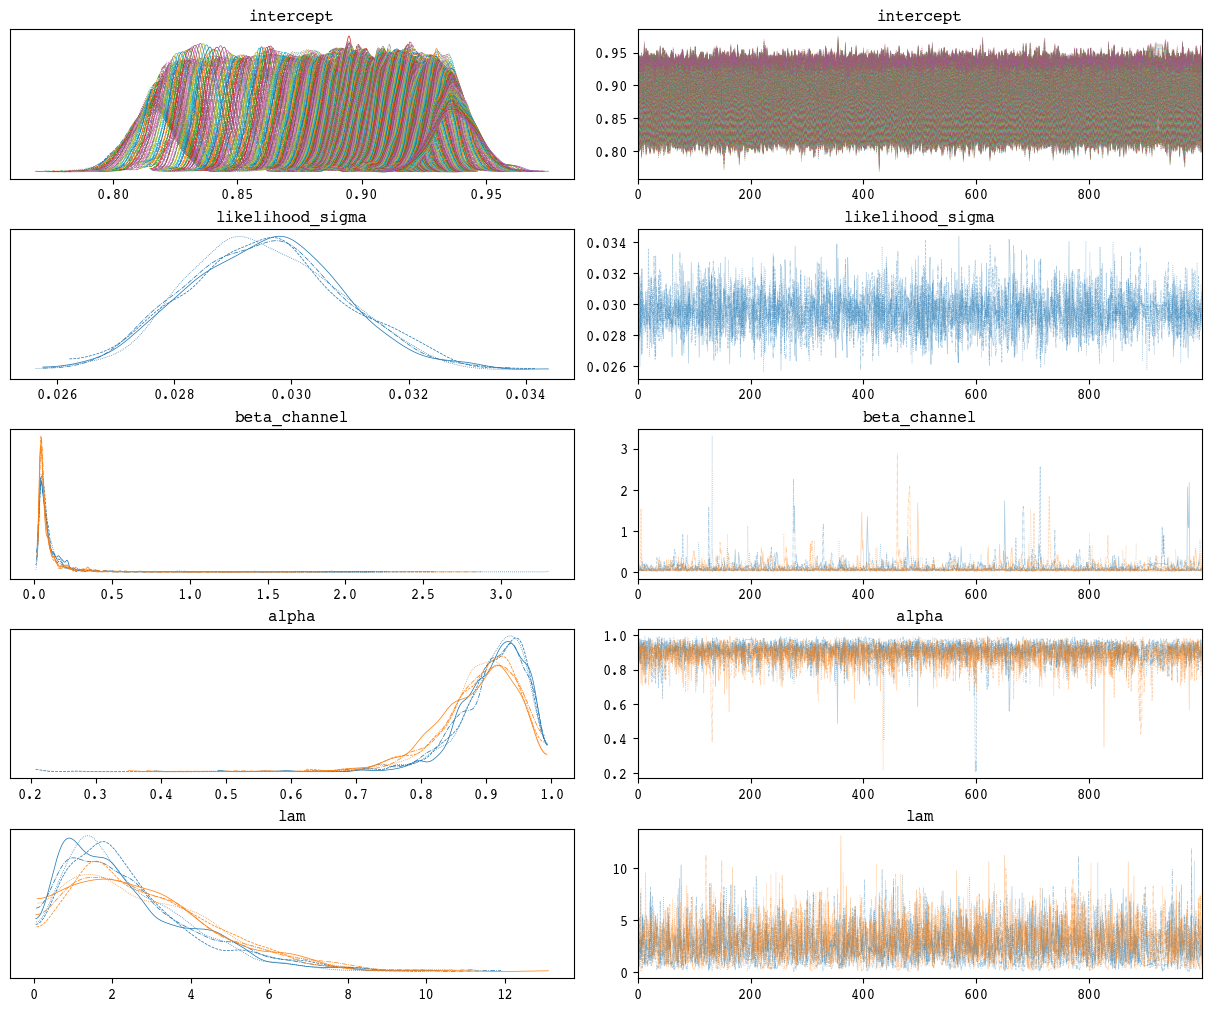

In [59]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

In [60]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 8MB
Dimensions:  (date: 255, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2021-02-07 2021-02-14 ... 2025-12-21
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 8MB 3.331e+03 3.555e+03 ... 3.736e+03
Attributes:
    created_at:                 2024-06-11T01:48:17.364158+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/sklearn/utils/deprecation.py:129: FutureWarning: Xt was renamed X in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/sklearn/utils/deprecation.py:129: FutureWarning: Xt was renamed X in version 1.5 and will be removed in 1.7.
  warnings.warn(


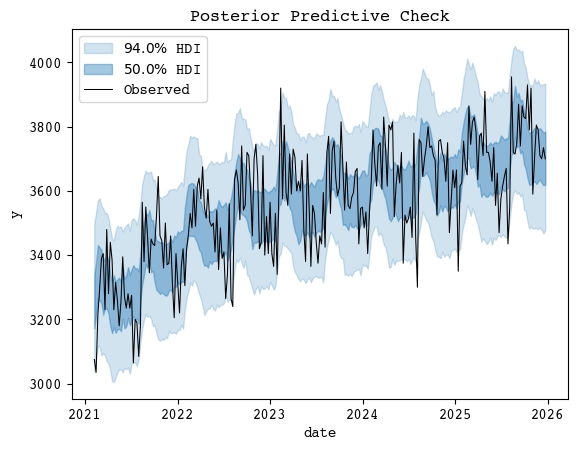

In [61]:
mmm.plot_posterior_predictive(original_scale=True);

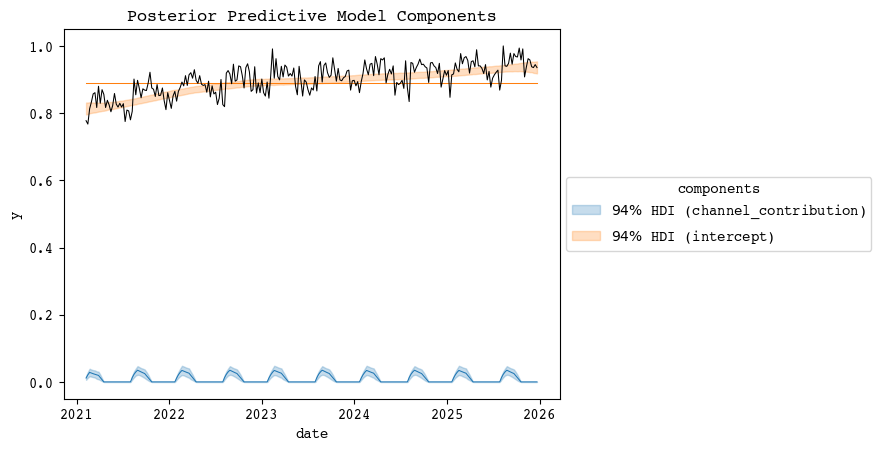

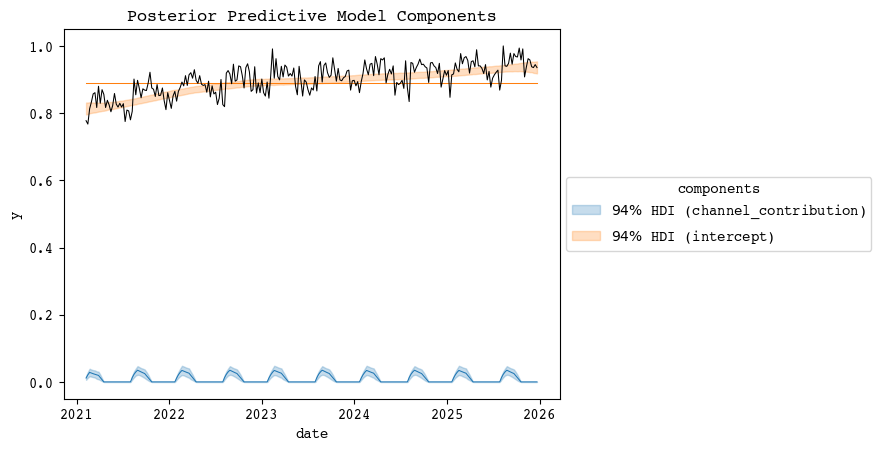

In [62]:
mmm.plot_components_contributions()

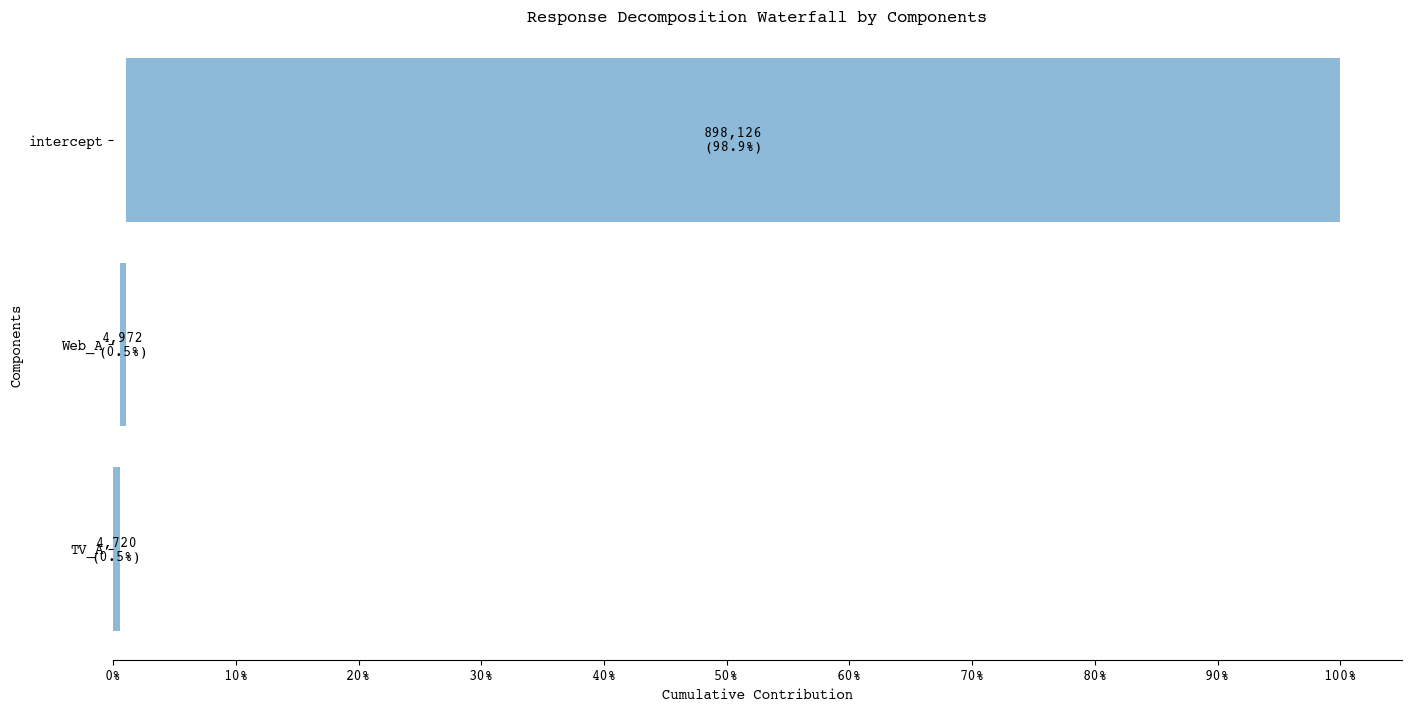

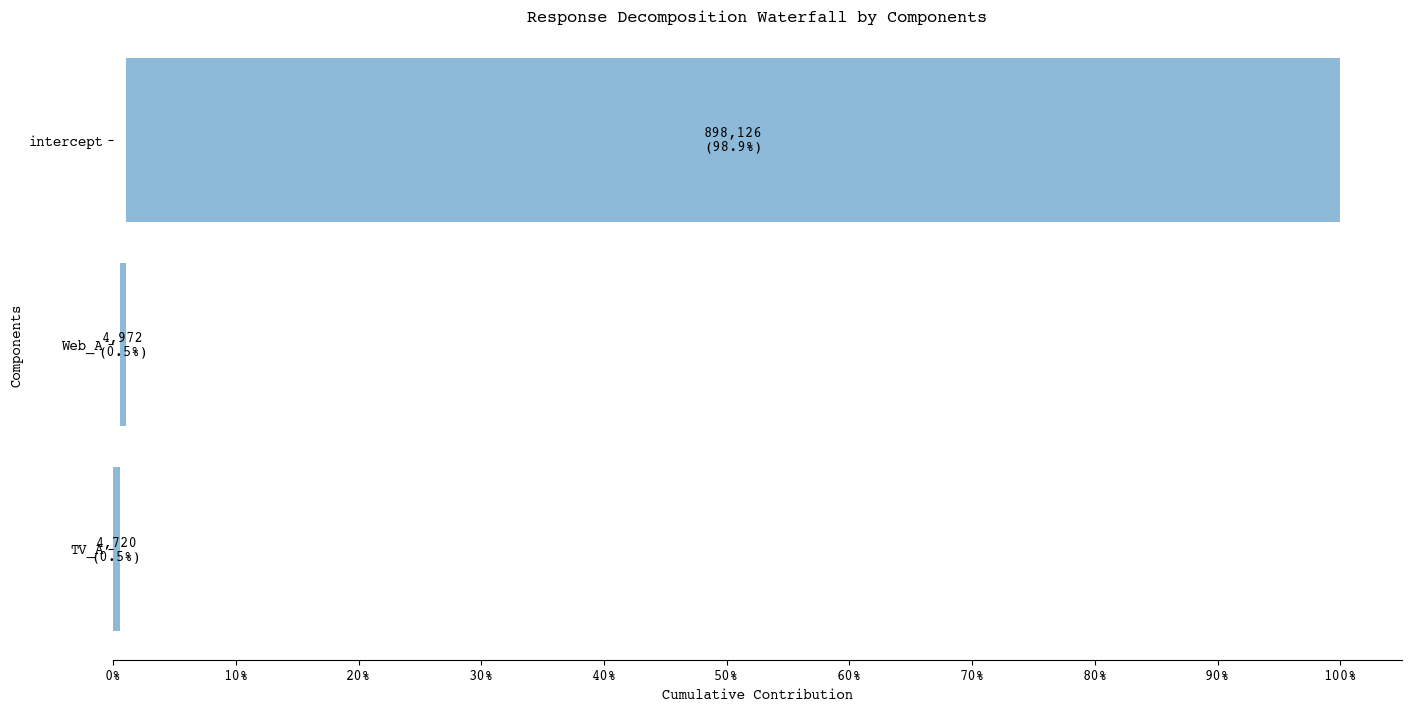

In [63]:
mmm.plot_waterfall_components_decomposition()

In [29]:
import pprint

In [30]:
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock_max_lag=4)
pprint.pprint(dummy_model.default_model_config)

{'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'b': 1, 'mu': 0}},
 'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
                'kwargs': {'sigma': {'dist': 'HalfNormal',
                                     'kwargs': {'sigma': 2}}}}}
